In [12]:
import numpy as np
import csv
import sys
import os

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
def plot_background_fct(send_data, recv_data, label, do_plot=True):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Background FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [14]:
def plot_foreground_fct(send_data, recv_data, label, do_plot=True):
    # diffs in micrseconds
    diffs = (recv_data - send_data) * 1000 * 1000
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="background FCT"+label) 
        ax1.set_title("Foreground FCT")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Microseconds')
        ax1.set_xlabel('Request ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [15]:
def plot_fanout(send_data, recv_data, label, do_plot=True, res_type="max"):
    # diffs in miliseconds
    diffs = (recv_data - send_data) * 1000
    if res_type=="max":
        diffs = np.max(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="avg":
        diffs = np.mean(diffs[:,:diffs.shape[1]-1],1)
    elif res_type=="min":
        diffs = np.min(diffs[:,:diffs.shape[1]-1],1)
        
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(diffs, label="RCT"+label) 
        ax1.set_title("Partition/Aggregate query completion time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Miliseconds')
        ax1.set_xlabel('Query ID')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   
        fig.show()
    return np.mean(diffs), np.percentile(diffs,99)

In [16]:
def servers_within_deadline(send_data, recv_data, deadline = 20):
    # diffs and deadline in miliseconds
    diffs = (recv_data - send_data) * 1000.0
    diffs_within_deadline = diffs < deadline
    num_serv_that_meet_deadline = np.sum(diffs_within_deadline,1)
    print(num_serv_that_meet_deadline.shape)
    num_serv_that_meet_deadline = np.sort(num_serv_that_meet_deadline, axis=0)
    end = int(np.round(0.01*num_serv_that_meet_deadline.shape[0]))
#     print(end)
    res_99 = np.mean(num_serv_that_meet_deadline[:end])
#     print(num_serv_that_meet_deadline[:end])
    return np.mean(num_serv_that_meet_deadline), res_99

In [17]:
def plot_queue_size(data, label, do_plot=True):
    # http://www.mathcs.emory.edu/~cheung/Courses/558-old/Syllabus/90-NS/trace.html
    # Columns are: Time(s)-fromNode-toNode-SizeB-SizePack-Packsarrived(in interval)
    # -departed - dropped -3: same in bytes
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    q_size_P = np.trim_zeros(q_size_P, trim='b')
    times = times[:q_size_B.shape[0]]
    
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    q_size_P = np.trim_zeros(q_size_P, trim='f')
    
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    if do_plot:
        fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
        ax1.plot(times, q_size_B, label="q_size in bytes "+label) 
        ax1.set_title("Q size vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Bytes')
        ax1.set_xlabel('Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        ax2.plot(times, q_size_P, label="q_size in packets "+label) 
        ax2.set_title("Q size vs Time")
        ax2.legend(loc='upper left')
        ax2.set_ylabel('Packets')
        ax2.set_xlabel('Seconds')
        ax2.grid(which='major', linestyle="-")
        ax2.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Q_size vs Time.png", format="png")
        fig.show()
    #avg_q_occup = np.mean(q_size_B)
    #print("Mon_mean: " + str(avg_q_occup))
    q_size_B = q_size_B/1000.0
    return np.mean(q_size_B), np.mean(q_size_P), np.percentile(q_size_B,99), np.percentile(q_size_P, 99)

In [18]:
def plot_queuing_time(data, label, link_speed, do_plot=True):
    """
    Link speed in Gbps
    results in microseconds
    """
    times = data[:,0]
    q_size_B, q_size_P = data[:,3], data[:,4]
    q_size_B = np.trim_zeros(q_size_B, trim='b')
    times = times[:q_size_B.shape[0]]
    q_size_B = np.trim_zeros(q_size_B, trim='f')
    times = times[times.shape[0] - q_size_B.shape[0]:]
    
    link_speed = link_speed * 1000.0 * 1000.0 * 1000.0
    q_time = q_size_B/(link_speed/8.0) * 1000.0 * 1000.0
    
    if do_plot:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
        ax1.plot(times, q_time, label="queuing delay "+label) 
        ax1.set_title("Queuing delay vs Time")
        ax1.legend(loc='upper left')
        ax1.set_ylabel('Queuing microseconds')
        ax1.set_xlabel('Simulation Seconds')
        ax1.grid(which='major', linestyle="-")
        ax1.grid(which='minor', linestyle='--')

        fig.tight_layout()   

        fig.savefig("Queuing delay vs Time.png", format="png")
        fig.show()
    return np.mean(q_time), np.percentile(q_time, 99)

In [19]:
def load_data(path, delimiter, start_time, main_col, target_length=-1):
    # remove any leading or trailing 0s based on the main information column    
    data = np.genfromtxt(path, delimiter=delimiter)
    if data.ndim == 1:
        data = data.reshape((data.shape[0],1))
#     print("initial data shape ", data.shape)
#     print("initial first time ", data[0,0])
#     print("initial last time ", data[data.shape[0]-1,0]) 
    tmp = np.trim_zeros(data[:,main_col], trim='b')
    data = data[:tmp.shape[0],:]
    tmp = np.trim_zeros(data[:,main_col], trim='f')
    data = data[data.shape[0] - tmp.shape[0]:,:]
    
    data = data[data[:,0]>=start_time]
    if target_length != -1:
        data = data[data.shape[0]-target_length:,:]
#     print("data shape ", data.shape)
#     print("first time ", data[0,0])
#     print("last time ", data[data.shape[0]-1,0])  
    
    return data

In [20]:
def print_results(fore=True, back=True, fanout_max=True, fanout_avg=True, fanout_min=True):
    print("Mean Q length in Kbytes {0} and in packets {1}\n99th percentile in Kbytes {2} and in packets {3}\n".format(bytes_mean, pkts_mean, bytes_99, pkts_99))
    print("Mean delay in us {0} and 99th percentile delay in us {1}\n".format(delay_mean, delay_99))
    if fore:
        print("Foreground FCT (us): mean: {0}, 99th %: {1}\n".format(frg_mean, frg_99))
    if back:
        print("Background FCT (ms): mean: {0}, 99th %: {1}\n".format(bkg_mean, bkg_99))
    if fanout_max:
        print("Fanout max QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_max_mean, fan_max_99))
    if fanout_avg:
        print("Fanout avg QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_avg_mean, fan_avg_99))
    if fanout_min:
        print("Fanout min QCT (ms): mean: {0}, 99th %: {1}\n".format(fan_min_mean, fan_min_99))
        print("Servers in deadline: mean: {0}, 99th %: {1}\n".format(servers_mean, servers_99))
        
    
    
    #print("Mean thrpt in Mbps {0} and 99th percentile thrpt in Mbps {1}".format(thrpt_mean, thrpt_99))    

## Just fanout, workload 0- 10 flows

In [21]:
results_folders = ["/TCP/", "/DCTCP30/", "/DCTCP_pacer_PQ/"]
latency = dict()
bkg_fct = dict()
frg_fct = dict()
fanout_qct_max = dict()
fanout_qct_avg = dict()
fanout_qct_min = dict()
servers_in_deadline = dict()

deadline = 1


for folder in results_folders:
    latency[folder] = []
    bkg_fct[folder] = []
    frg_fct[folder] = []
    fanout_qct_max[folder] = []
    fanout_qct_avg[folder] = []
    fanout_qct_min[folder] = []    
    servers_in_deadline[folder] = []        

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(50186,)
/TCP/
Mean Q length in Kbytes 7.986298719076973e-06 and in packets 9.234433759312583e-05
99th percentile in Kbytes 0.00024521323441223635 and in packets 0.0028078313112806005

Mean delay in us 6.389038975261579e-05 and 99th percentile delay in us 0.0019617058752978904

Fanout max QCT (ms): mean: 0.13724855054117027, 99th %: 0.21707782548956459

Fanout avg QCT (ms): mean: 0.13220007711294454, 99th %: 0.21203782549301678

Fanout min QCT (ms): mean: 0.12715172993506776, 99th %: 0.2069176019952047

Servers in deadline: mean: 10.0, 99th %: 10.0

(50186,)
/DCTCP30/
Mean Q length in Kbytes 7.986298719076973e-06 and in packets 9.234433759312583e-05
99th percentile in Kbytes 0.00024521323441223635 and in packets 0.0028078313112806005

Mean delay in us 6.389038975261579e-05 and 99th percentile delay in us 0.0019617058752978904

Fanout max QCT (ms): mean: 0.13724855054117027, 99th %: 0.21707782548956459

Fanout avg QCT (ms): mean: 0.13220007711294454, 99th %: 0.21203782549301678

Fanout 

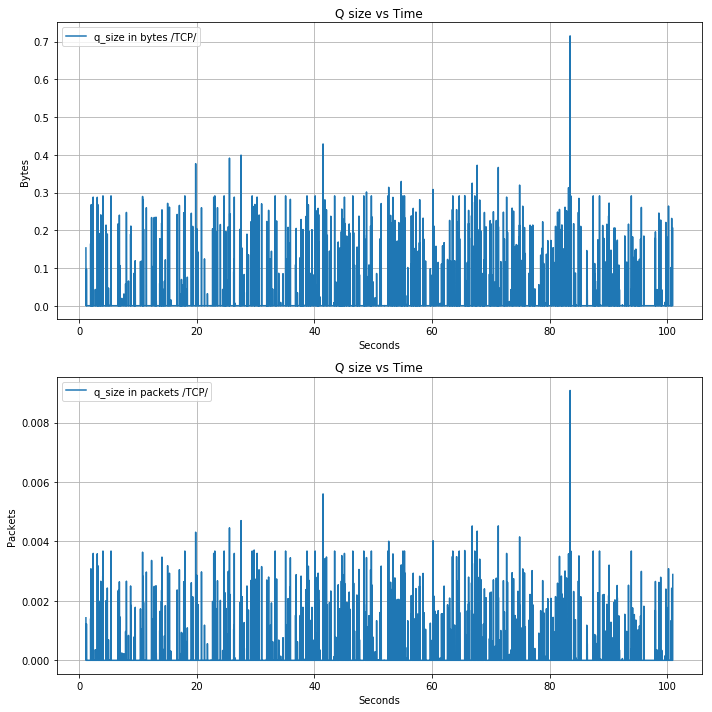

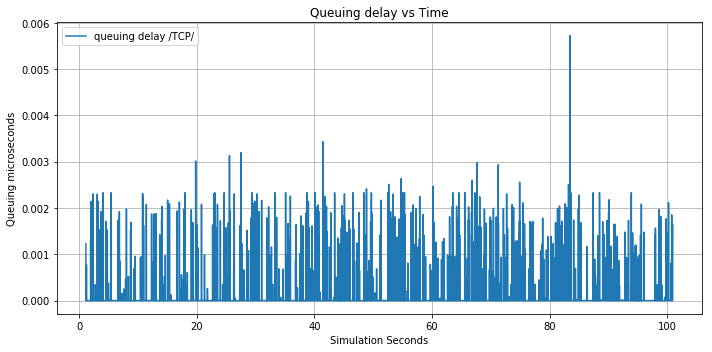

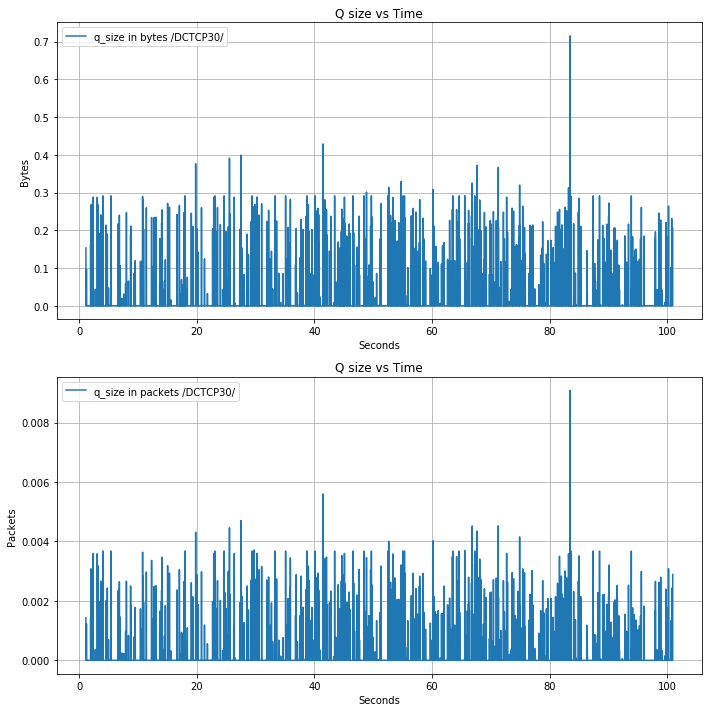

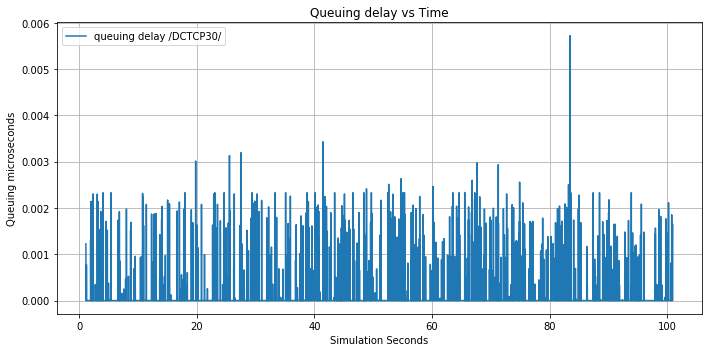

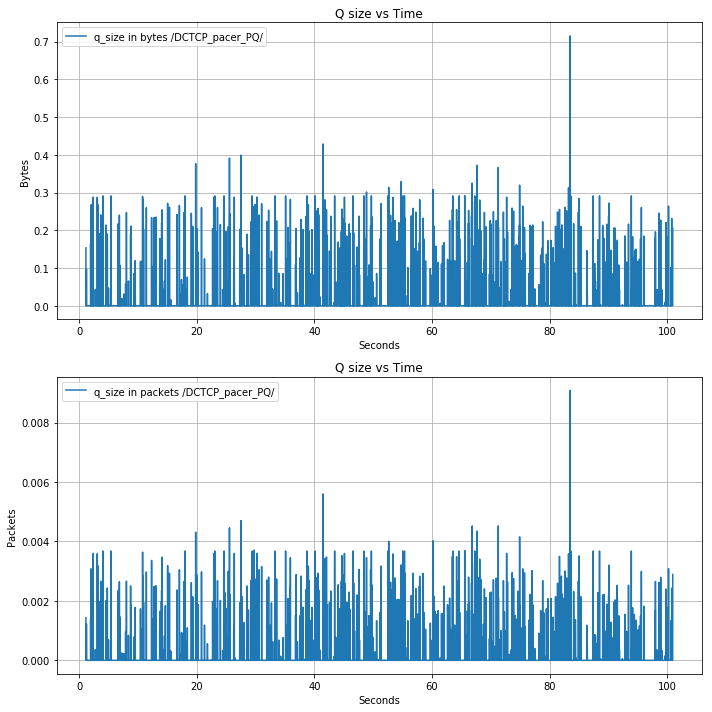

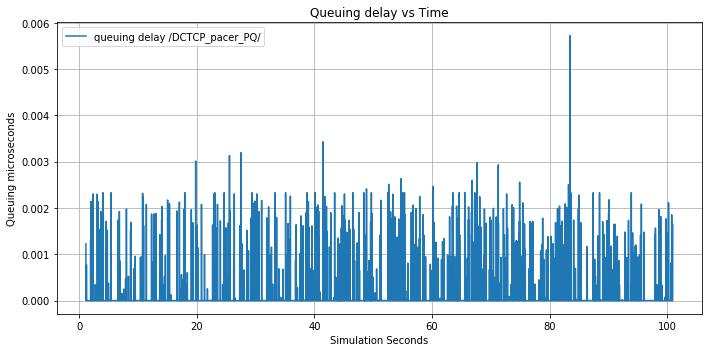

In [22]:
simul_folder = "onlyfanout_wkld0_5_10flows"
stable_state_offset = 0
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    

    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=False, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    nothing ever
    """

## Fanout, workload 0 + background traffic at 200Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(50186,)
/TCP/
Mean Q length in Kbytes 14.46813269729133 and in packets 15.690846470092865
99th percentile in Kbytes 267.32017512884005 and in packets 291.02743164965824

Mean delay in us 115.74506157833063 and 99th percentile delay in us 2138.5614010307204

Background FCT (ms): mean: 106.6314974349557, 99th %: 249.49437304479267

Fanout max QCT (ms): mean: 0.3744095110004988, 99th %: 2.782726602718189

Fanout avg QCT (ms): mean: 0.26557036950153856, 99th %: 2.290912432741159

Fanout min QCT (ms): mean: 0.24584309016919967, 99th %: 2.2742996837074267

Servers in deadline: mean: 9.511198342167138, 99th %: 0.0

(50186,)
/DCTCP30/
Mean Q length in Kbytes 4.855297301101513 and in packets 5.281343031239801
99th percentile in Kbytes 33.22581180814679 and in packets 36.49249530322085

Mean delay in us 38.8423784088121 and 99th percentile delay in us 265.80649446517424

Background FCT (ms): mean: 109.82086496813908, 99th %: 280.84128404935575

Fanout max QCT (ms): mean: 0.2437551210643498, 99t

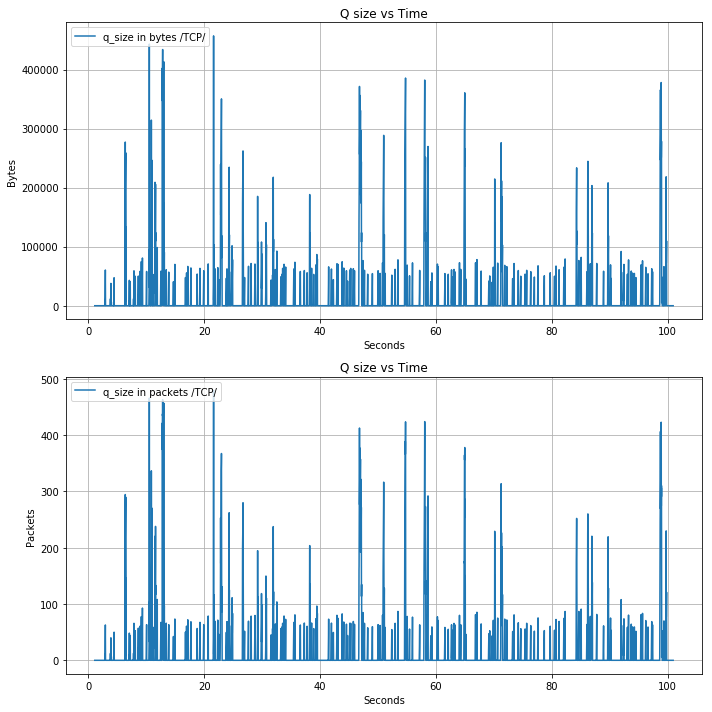

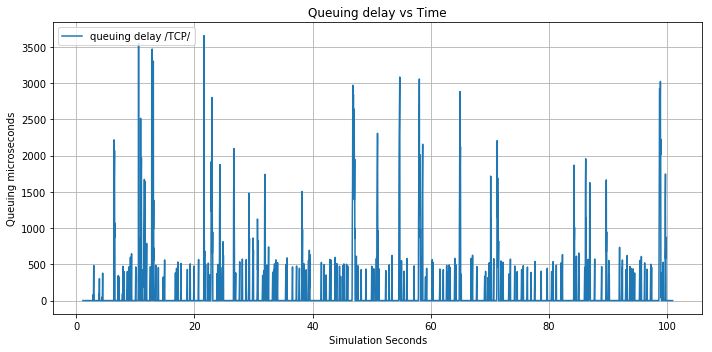

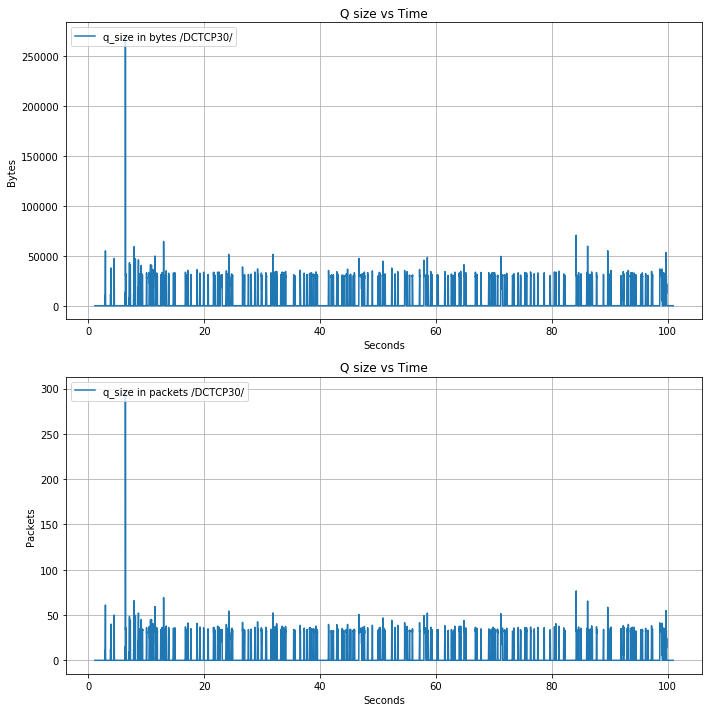

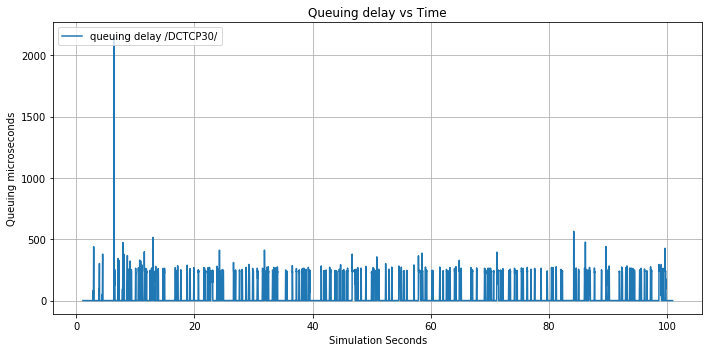

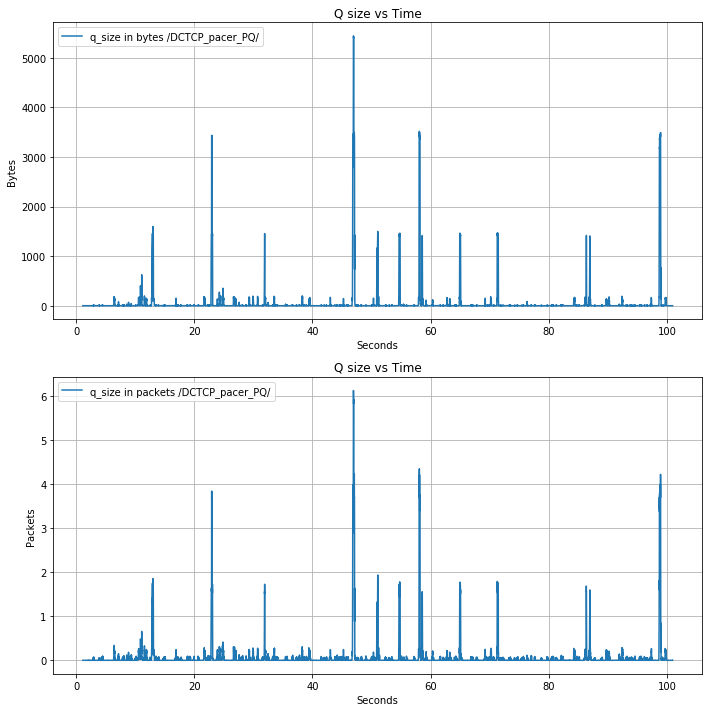

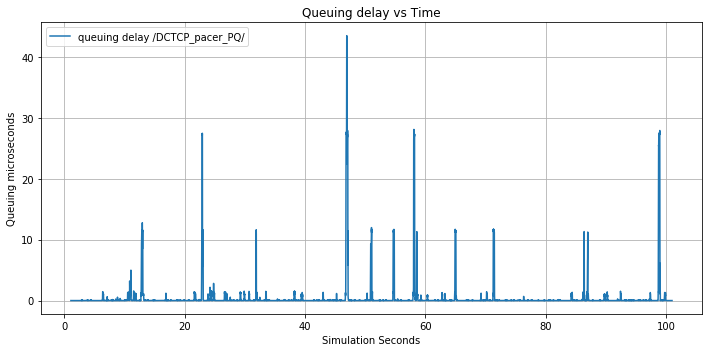

In [23]:
simul_folder = "bkg200_fanout_wkld0_5_10flows"
stable_state_offset = 0
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,190)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,14592)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,107)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 0 + background traffic at 400Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(47207,)
/TCP/
Mean Q length in Kbytes 42.184783732679975 and in packets 45.78855109780827
99th percentile in Kbytes 328.3390321692644 and in packets 356.8666868890034

Mean delay in us 337.4782698614398 and 99th percentile delay in us 2626.712257354115

Background FCT (ms): mean: 128.99947859102716, 99th %: 405.18259350748406

Fanout max QCT (ms): mean: 0.6113675473235824, 99th %: 2.8515553889822383

Fanout avg QCT (ms): mean: 0.49660675336719423, 99th %: 2.836435303238121

Fanout min QCT (ms): mean: 0.47566655213447945, 99th %: 2.818676371458581

Servers in deadline: mean: 8.363971444912831, 99th %: 0.0

(47207,)
/DCTCP30/
Mean Q length in Kbytes 10.816928899941804 and in packets 11.75706564887939
99th percentile in Kbytes 34.03948921156394 and in packets 38.031855670641804

Mean delay in us 86.53543119953443 and 99th percentile delay in us 272.3159136925115

Background FCT (ms): mean: 138.61091690262703, 99th %: 403.5007012846037

Fanout max QCT (ms): mean: 0.2988484753344491, 99th 

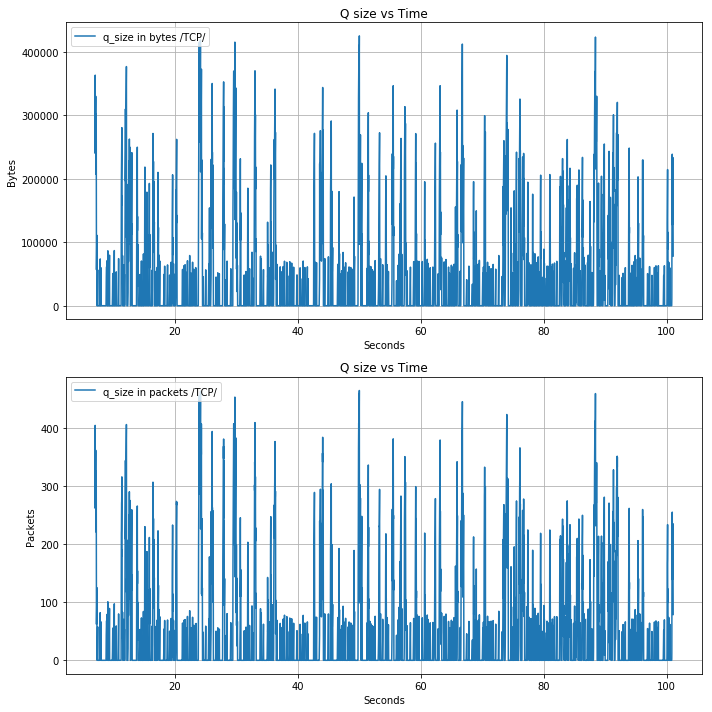

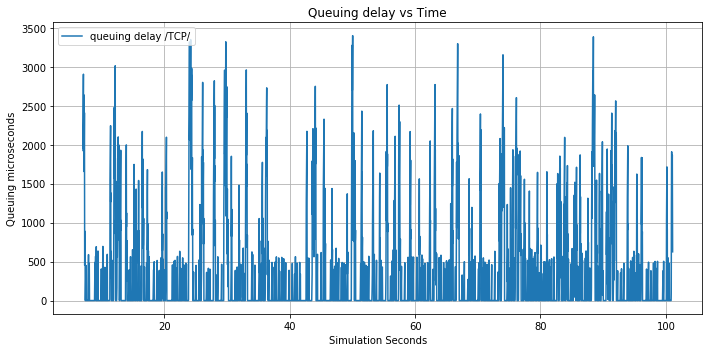

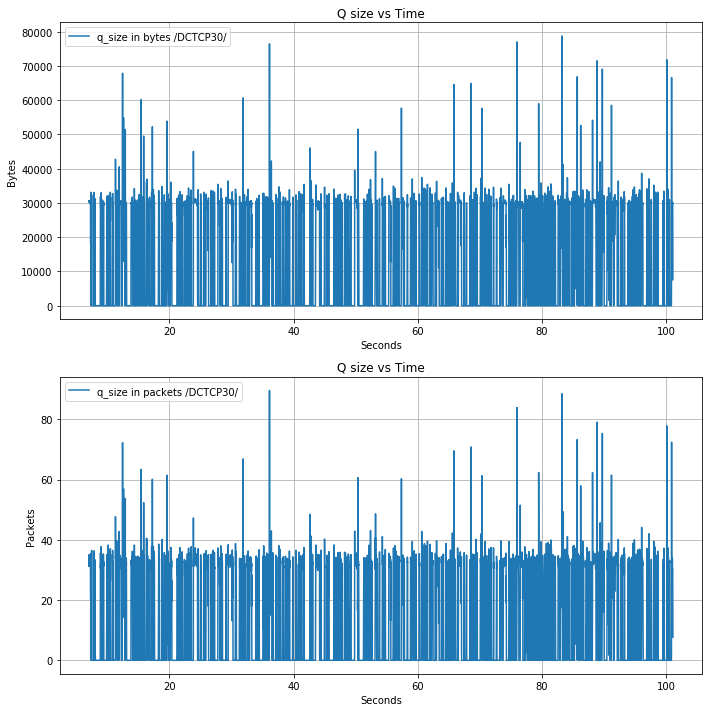

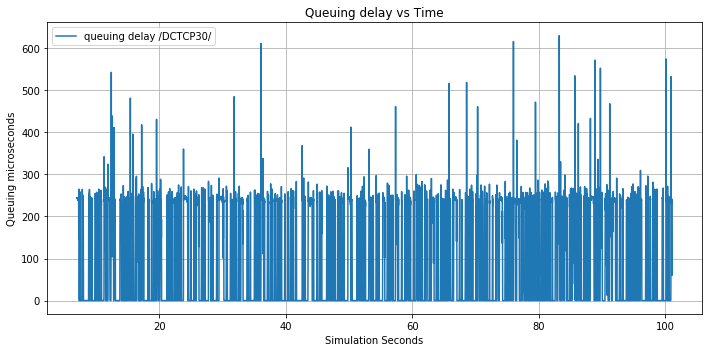

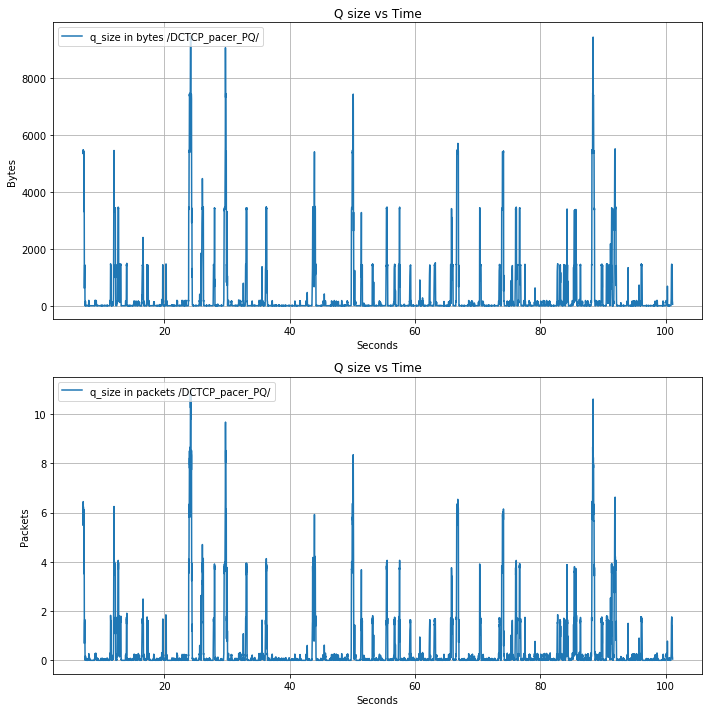

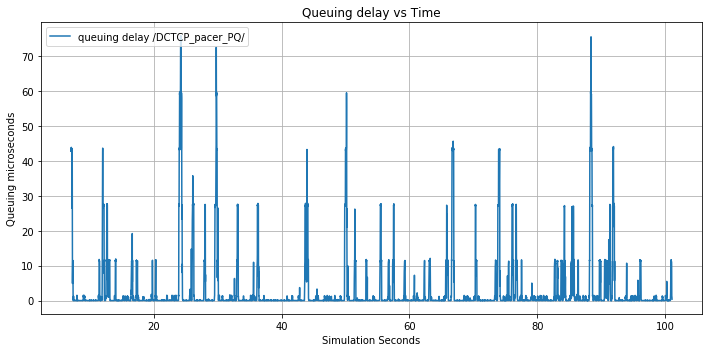

In [24]:
simul_folder = "bkg400_fanout_wkld0_5_10flows"

stable_state_offset = 7
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,1028)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,38172)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,544)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,68)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

## Fanout, workload 0 + background traffic at 600Mbps - 10 flows 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


(47207,)
/TCP/
Mean Q length in Kbytes 94.86909390311781 and in packets 102.84612048843043
99th percentile in Kbytes 402.01640748134855 and in packets 437.31393598651323

Mean delay in us 758.9527512249425 and 99th percentile delay in us 3216.1312598507884

Background FCT (ms): mean: 191.96361228263387, 99th %: 667.1916175671311

Fanout max QCT (ms): mean: 1.0509244743701978, 99th %: 3.4932957994331573

Fanout avg QCT (ms): mean: 0.9346261196446483, 99th %: 3.461395668600617

Fanout min QCT (ms): mean: 0.8988422673709048, 99th %: 3.3829571267824576

Servers in deadline: mean: 6.337068655072341, 99th %: 0.0

(47207,)
/DCTCP30/
Mean Q length in Kbytes 17.006782449686003 and in packets 18.476507085667432
99th percentile in Kbytes 35.91432446507496 and in packets 39.683626434109875

Mean delay in us 136.05425959748803 and 99th percentile delay in us 287.3145957205997

Background FCT (ms): mean: 211.00743192442766, 99th %: 708.763441661651

Fanout max QCT (ms): mean: 0.3473230065442093, 99t

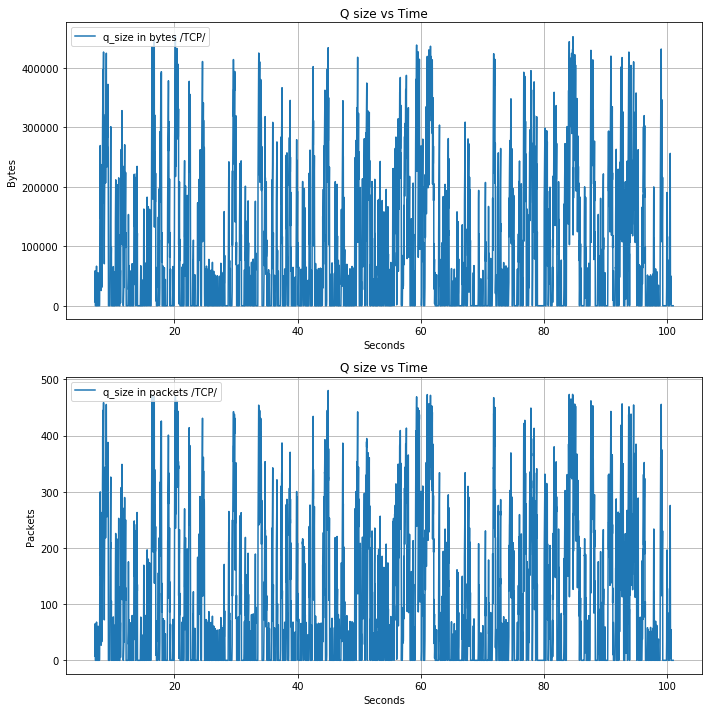

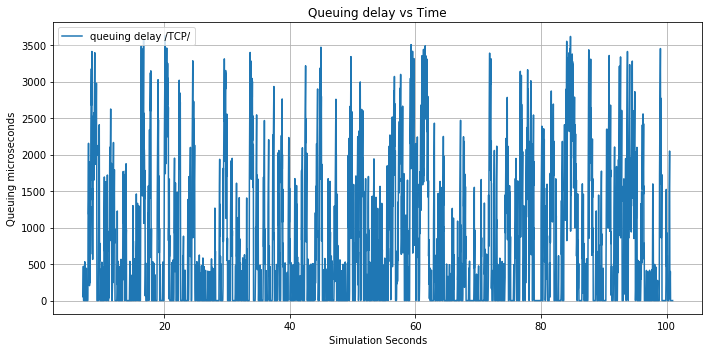

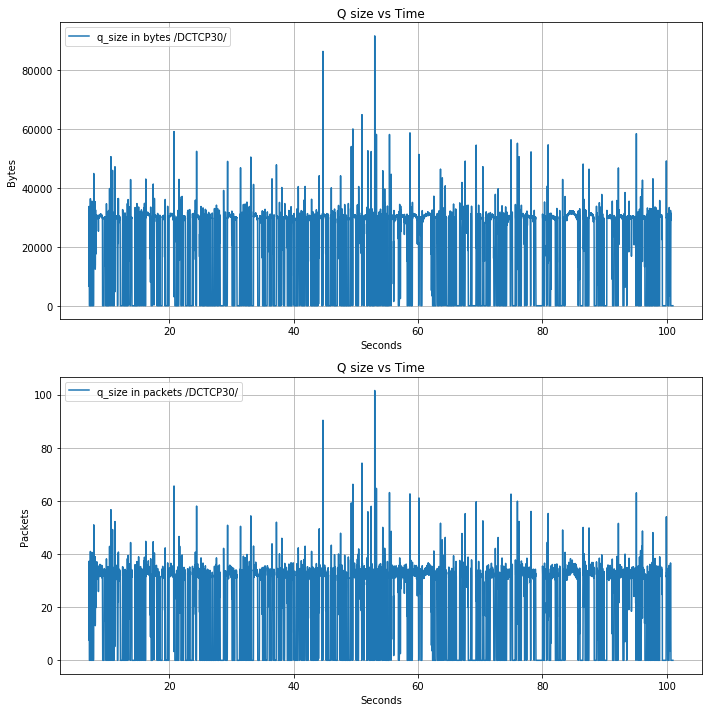

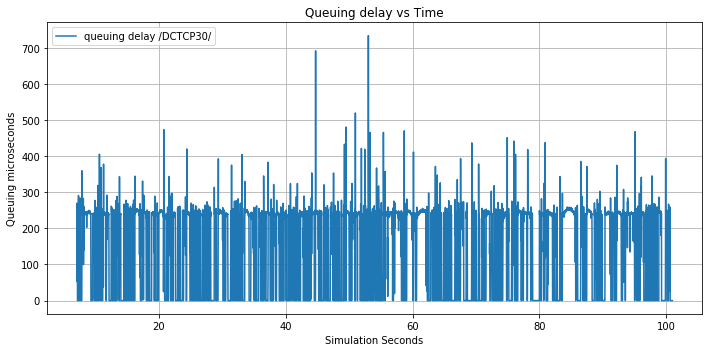

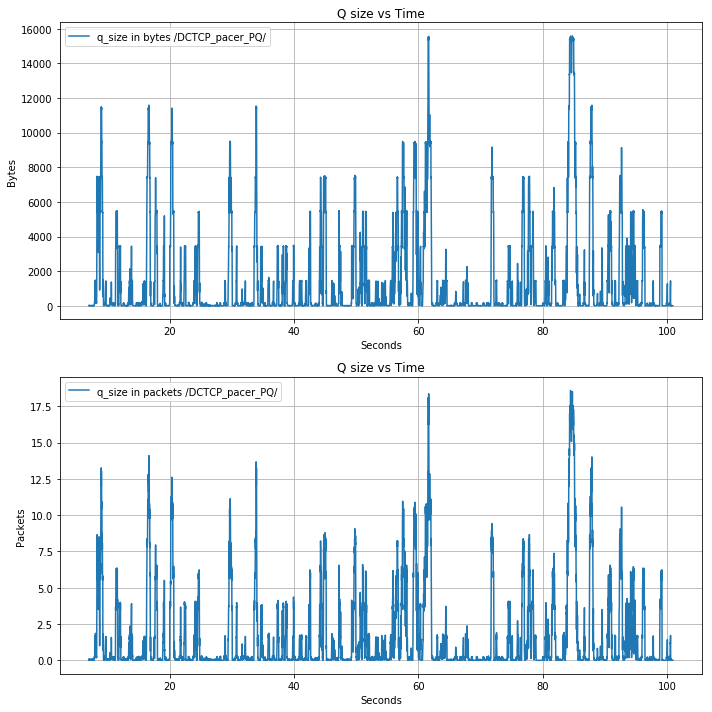

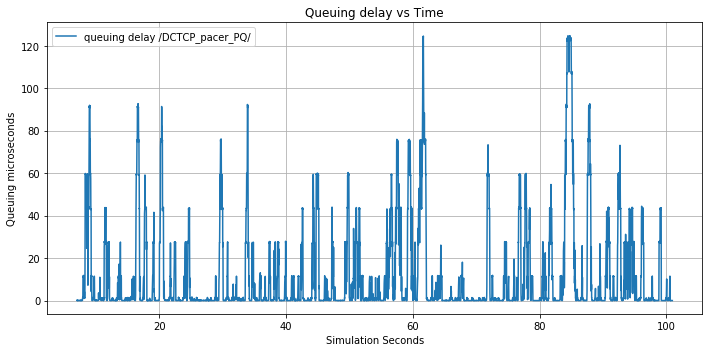

In [25]:
simul_folder = "bkg600_fanout_wkld0_5_10flows"

stable_state_offset = 7
for folder in results_folders:
    path = simul_folder + folder
    q_mon = load_data(path+"q_mon", " ", stable_state_offset, 3)
    bytes_mean,pkts_mean,bytes_99,pkts_99 = plot_queue_size(q_mon, folder, do_plot=True)
    delay_mean, delay_99 = plot_queuing_time(q_mon, folder, 1, do_plot=True)
    latency[folder].append((delay_mean, delay_99))
    
    bkg_send = load_data(path+"send_times|background.csv", " ", stable_state_offset, 0)
    bkg_recv = load_data(path+"rec_times|background.csv", " ", stable_state_offset, 0, bkg_send.shape[0])
    
    bkg_mean, bkg_99 = plot_background_fct(bkg_send, bkg_recv, folder, do_plot=False)
    bkg_fct[folder].append((bkg_mean,bkg_99))
    
    fan_send = load_data(path+"send_times|fanout.csv", ",", stable_state_offset, 0)
    fan_recv = load_data(path+"rec_times|fanout.csv", ",", stable_state_offset, 0, fan_send.shape[0])
    
    fan_max_mean, fan_max_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False)
    fanout_qct_max[folder].append((fan_max_mean,fan_max_99))
    
    fan_avg_mean, fan_avg_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="avg")
    fanout_qct_avg[folder].append((fan_avg_mean,fan_avg_99))
    
    fan_min_mean, fan_min_99 = plot_fanout(fan_send, fan_recv, folder, do_plot=False, res_type="min")
    fanout_qct_min[folder].append((fan_min_mean,fan_min_99))
    
    servers_mean, servers_99 = servers_within_deadline(fan_send, fan_recv, deadline)
    servers_in_deadline[folder].append((servers_mean,servers_99))
    
    print(folder)
    print_results(fore=False, back=True, fanout_max=True, fanout_avg=True, fanout_min=True)
    """
    (0,2439)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,72058)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    (0,1344)(1,0)(2,0)(3,0)(4,0)(5,0)(6,0)(7,0)(8,0)(9,0)(10,90)(11,0)(12,0)(13,0)(14,0)(15,0)(16,0)(17,0)(18,0)(19,0)
    """

In [26]:
print("--------latency----------")
print(latency)
print("--------bkg----------")
print(bkg_fct)
print("--------fan_max----------")
print(fanout_qct_max)
print("--------fan_avg---------")
print(fanout_qct_avg)
print("--------fan_min---------")
print(fanout_qct_min)
print("--------quality---------")
print(servers_in_deadline)


--------latency----------
{'/TCP/': [(6.389038975261579e-05, 0.0019617058752978904), (115.74506157833063, 2138.5614010307204), (337.4782698614398, 2626.712257354115), (758.9527512249425, 3216.1312598507884)], '/DCTCP30/': [(6.389038975261579e-05, 0.0019617058752978904), (38.8423784088121, 265.80649446517424), (86.53543119953443, 272.3159136925115), (136.05425959748803, 287.3145957205997)], '/DCTCP_pacer_PQ/': [(6.389038975261579e-05, 0.0019617058752978904), (0.45183082547889925, 11.531547347842265), (2.915641959772082, 43.54633189341791), (11.627186941858602, 106.72915942176508)]}
--------bkg----------
{'/TCP/': [(106.6314974349557, 249.49437304479267), (128.99947859102716, 405.18259350748406), (191.96361228263387, 667.1916175671311)], '/DCTCP30/': [(109.82086496813908, 280.84128404935575), (138.61091690262703, 403.5007012846037), (211.00743192442766, 708.763441661651)], '/DCTCP_pacer_PQ/': [(196.08603029586192, 306.0903598209286), (229.48675287337983, 428.3377769255254), (297.88525687

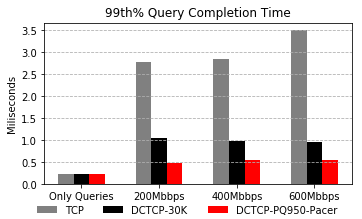

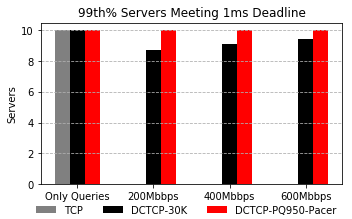

In [27]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
config_num = 4
ind = np.arange(config_num)
width = 0.2
x_axis_labels = ('Only Queries', '200Mbbps', '400Mbbps', '600Mbbps')
# qct max
res = []
for folder in results_folders:
    res.append([x[1] for x in fanout_qct_max[folder]])

p1 = ax1.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax1.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax1.bar(ind+1.5*width, res[2], width, color='r')


ax1.set_title('99th% Query Completion Time')
ax1.set_xticks(ind + width / 2)
ax1.set_xticklabels(x_axis_labels)
ax1.set_ylabel('Miliseconds')
ax1.yaxis.grid(linestyle="--")

fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()



fig, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
# Quality
res = []
for folder in results_folders:
    res.append([x[1] for x in servers_in_deadline[folder]])
p1 = ax3.bar(ind-0.5*width, res[0], width, color='grey')
p2 = ax3.bar(ind+0.5*width, res[1], width, color='k')
p3 = ax3.bar(ind+1.5*width, res[2], width, color='r')


ax3.set_title('99th% Servers Meeting 1ms Deadline')
ax3.set_xticks(ind + width / 2)
ax3.set_xticklabels(x_axis_labels)
ax3.set_ylabel('Servers')
ax3.yaxis.grid(linestyle="--")





fig.legend((p1[0], p2[0], p3[0]), ('TCP', 'DCTCP-30K', 'DCTCP-PQ950-Pacer'), loc= (0.09,0), ncol=4, fancybox=False,frameon=False)
fig.subplots_adjust(bottom = 0.3)
val = - 1
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=val, hspace=val)

fig.tight_layout()
fig.show()